In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Настройка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

# Чтение файла
df = pd.read_csv('bs140513_032310.csv')

labels=['zipcodeOri', 'zipMerchant']
df=df.drop(labels, axis=1, inplace=False, errors='raise')



# Убедимся, что данные отсортированы по времени (важно для "до текущего дня")
df = df.sort_values(['customer', 'step']).reset_index(drop=True)

# 1. Общее количество транзакций за всё время для клиента
df['cust_total_tx'] = df.groupby('customer')['step'].transform('count')

# 2. Количество уникальных мерчантов, с которыми клиент взаимодействовал (всё время)
df['cust_unique_merch_total'] = df.groupby('customer')['merchant'].transform('nunique')

# 3. Сколько транзакций у клиента до текущего дня (исключая текущую)
# Для этого используем cumulative count - 1
df['cust_tx_before'] = df.groupby('customer').cumcount()

# 4. Сколько уникальных мерчантов у клиента до текущего дня
# Нужно аккуратно: считаем уникальные merchant_id до текущей строки
def count_unique_before(series):
    # series — это merchant_id для одного клиента, отсортированный по day
    seen = set()
    result = []
    for merch in series:
        result.append(len(seen))
        seen.add(merch)
    return result

df['cust_unique_merch_before'] = df.groupby('customer')['merchant'].transform(count_unique_before)

# 5. Бинарный признак: первая ли это транзакция клиента?
df['is_first_tx'] = (df['cust_tx_before'] == 0).astype(int)

# 6. Взаимодействовал ли клиент с этим мерчантом раньше? (до текущей транзакции)
def has_seen_merchant(group):
    seen = set()
    res = []
    for merch in group['merchant']:
        res.append(1 if merch in seen else 0)
        seen.add(merch)
    return res

df['seen_merchant_before'] = df.groupby('customer').apply(has_seen_merchant).explode().values.astype(int)

# 7. Доля дней с транзакциями (всё время)
# Сначала посчитаем уникальные дни у клиента
cust_unique_days = df.groupby('customer')['step'].nunique()
df['cust_unique_days'] = df['customer'].map(cust_unique_days)
df['cust_tx_days_ratio'] = df['cust_unique_days'] / 180.0  # 180 — общее число дней

# 8. Максимальное число транзакций за один день (всё время)
daily_counts = df.groupby(['customer', 'step']).size().reset_index(name='daily_tx')
max_daily = daily_counts.groupby('customer')['daily_tx'].max()
df['cust_max_tx_per_day'] = df['customer'].map(max_daily)

# 9. Средний интервал между транзакциями (всё время)
def avg_interval(days):
    if len(days) <= 1:
        return np.nan  # или 0, но лучше NaN
    diffs = np.diff(sorted(days))
    return diffs.mean()

cust_avg_int = df.groupby('customer')['step'].apply(avg_interval)
df['cust_avg_interval'] = df['customer'].map(cust_avg_int)

# 10. Среднее число транзакций в день у клиента (до текущего дня)
# = cust_tx_before / (текущий день - первый день активности + 1), но проще:
# Будем считать как: (число транзакций до текущего дня) / (число дней от первой транзакции до текущего дня)
def avg_tx_per_day_before(group):
    days = group['step'].values
    tx_counts = np.arange(len(days))  # 0, 1, 2, ..., n-1
    first_day = days[0]
    result = []
    for i, day in enumerate(days):
        if i == 0:
            result.append(0.0)  # или np.nan
        else:
            span_days = day - first_day
            if span_days == 0:
                result.append(np.nan)
            else:
                result.append(tx_counts[i] / span_days)
    return result

df['cust_avg_tx_per_day_before'] = df.groupby('customer').apply(
    lambda g: pd.Series(avg_tx_per_day_before(g), index=g.index)
).values

# 11. Количество транзакций за последние 7 дней (до текущего дня, не включая текущую)
# Используем rolling window по day (но day — не обязательно последовательные индексы)
# Поэтому делаем через цикл или merge с временным окном

# Создадим вспомогательный датафрейм для rolling-подсчёта
df_sorted = df.copy()
df_sorted = df_sorted.sort_values(['customer', 'step'])

# Инициализируем колонку
df_sorted['tx_last_7_days'] = 0

# Группируем по клиенту и считаем для каждой транзакции
for cust_id, group in df_sorted.groupby('customer'):
    days = group['step'].values
    indices = group.index
    counts = []
    for i, current_day in enumerate(days):
        # Считаем транзакции в диапазоне (current_day - 7, current_day)
        start_day = current_day - 7
        # Только предыдущие транзакции (строго < current_day)
        count = np.sum((days[:i] > start_day) & (days[:i] < current_day))
        counts.append(count)
    df_sorted.loc[indices, 'tx_last_7_days'] = counts

# Вернём результат в исходный порядок (если был)
df = df_sorted.sort_index().reset_index(drop=True)




# # Столбцы для анализа
# columns_to_analyze = list(range(0, 19))

# # Получаем названия столбцов по индексам
# column_names = df.columns[columns_to_analyze].tolist()

# print("Анализируемые столбцы:")
# for i, col in enumerate(column_names):
#     print(f"{i+1}. {col}")

# # Создаем subplot для всех графиков
# fig, axes = plt.subplots(4, 6, figsize=(24, 20))
# axes = axes.ravel()

# # Удаляем лишние subplot'ы если столбцов меньше 16
# for i in range(len(column_names), len(axes)):
#     fig.delaxes(axes[i])

# # Анализ для каждого столбца
# for i, column in enumerate(column_names):
#     if i >= len(axes):
#         break

#     ax = axes[i]

#     # Проверяем тип данных столбца
#     dtype = df[column].dtype

#     # Для категориальных данных - топ 10 категорий
#     if df[column].dtype == 'object' or df[column].nunique() <= 15:
#         # Считаем процентное распределение
#         value_counts = df[column].value_counts(normalize=True) * 100

#         # Берем топ-10 категорий
#         if len(value_counts) > 10:
#             top_categories = value_counts.head(10)
#             plot_data = top_categories
#         else:
#             plot_data = value_counts

#         # Создаем круговую диаграмму
#         wedges, texts, autotexts = ax.pie(plot_data.values, labels=plot_data.index,
#                                          autopct='%1.1f%%', startangle=90,
#                                          colors=plt.cm.Set3(np.linspace(0, 1, len(plot_data))))

#         # Настраиваем внешний вид
#         for autotext in autotexts:
#             autotext.set_color('black')
#             autotext.set_fontweight('bold')
#             autotext.set_fontsize(8)

#         ax.set_title(f'{column}\n(категориальный - топ {len(plot_data)} категорий)',
#                     fontsize=11, fontweight='bold', pad=20)

#     # Для числовых данных - простое распределение
#     else:
#         data = df[column].dropna()

#         # Создаем гистограмму
#         n, bins, patches = ax.hist(data, bins=30, alpha=0.7, edgecolor='black',
#                                  color='skyblue', density=False)

#         # Добавляем статистику на график
#         stats_text = f'Всего: {len(data):,}\nМедиана: {data.median():.2f}\nСреднее: {data.mean():.2f}'
#         ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
#                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#                fontsize=9, fontweight='bold')

#         ax.set_title(f'{column}\n(числовой - распределение)', fontsize=11, fontweight='bold')
#         ax.set_xlabel(column)
#         ax.set_ylabel('Частота')
#         ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.suptitle('Анализ распределения данных по столбцам \nFinancial Fraud Detection Dataset',
#              fontsize=18, fontweight='bold', y=1.02)
# plt.show()




# print("\n" + "="*80)
# print("ПОДРОБНАЯ СВОДНАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ")
# print("="*80)

# detailed_stats = []

# for column in column_names:
#     dtype = df[column].dtype
#     total_count = len(df[column])
#     non_null_count = df[column].count()

#     if df[column].dtype == 'object' or df[column].nunique() <= 15:
#         # Для категориальных - топ 10 категорий
#         value_counts = df[column].value_counts(normalize=True) * 100
#         top_categories = " | ".join([f"{cat}: {pct:.1f}%" for cat, pct in value_counts.head(10).items()])
#         stats_type = "категориальный"
#         groups_info = f"Топ-{len(value_counts)} категорий"
#     else:
#         # Для числовых - базовая статистика
#         data = df[column].dropna()
#         stats_type = "числовой"
#         groups_info = f"Min: {data.min():.2f} | Max: {data.max():.2f} | Mean: {data.mean():.2f} | Median: {data.median():.2f}"

#     detailed_stats.append({
#         'Столбец': column,
#         'Тип': stats_type,
#         'Всего записей': total_count,
#         'Не пустых': non_null_count,
#         'Заполненность': f"{(non_null_count/total_count)*100:.1f}%",
#         'Информация': groups_info
#     })

# stats_df = pd.DataFrame(detailed_stats)
# print(stats_df.to_string(index=False, max_colwidth=40))

# # Столбцы для анализа
# columns_to_analyze = list(range(0, 19))

# # Получаем названия столбцов по индексам
# column_names = df.columns[columns_to_analyze].tolist()

# print("Анализируемые столбцы:")
# for i, col in enumerate(column_names):
#     print(f"{i+1}. {col}")

# # Создаем subplot для всех графиков
# fig, axes = plt.subplots(4, 6, figsize=(24, 20))
# axes = axes.ravel()

# # Удаляем лишние subplot'ы если столбцов меньше 16
# for i in range(len(column_names), len(axes)):
#     fig.delaxes(axes[i])

# # Анализ для каждого столбца
# for i, column in enumerate(column_names):
#     if i >= len(axes):
#         break

#     ax = axes[i]

#     # Проверяем тип данных столбца
#     dtype = df[column].dtype

#     # Для категориальных данных - топ 10 категорий
#     if df[column].dtype == 'object' or df[column].nunique() <= 15:
#         # Считаем процентное распределение
#         value_counts = df[df['fraud']==1][column].value_counts(normalize=True) * 100                     #ВОТ ТУТ ИЗМЕНЕНИЯ

#         # Берем топ-10 категорий
#         if len(value_counts) > 10:
#             top_categories = value_counts.head(10)
#             plot_data = top_categories
#         else:
#             plot_data = value_counts

#         # Создаем круговую диаграмму
#         wedges, texts, autotexts = ax.pie(plot_data.values, labels=plot_data.index,
#                                          autopct='%1.1f%%', startangle=90,
#                                          colors=plt.cm.Set3(np.linspace(0, 1, len(plot_data))))

#         # Настраиваем внешний вид
#         for autotext in autotexts:
#             autotext.set_color('black')
#             autotext.set_fontweight('bold')
#             autotext.set_fontsize(8)

#         ax.set_title(f'{column}\n(категориальный - топ {len(plot_data)} категорий)',
#                     fontsize=11, fontweight='bold', pad=20)

#     # Для числовых данных - простое распределение
#     else:
#         data = df[df['fraud']==1][column].dropna()                                 #ВОТ ТУТ ИЗМЕНЕНИЯ

#         # Создаем гистограмму
#         n, bins, patches = ax.hist(data, bins=30, alpha=0.7, edgecolor='black',
#                                  color='skyblue', density=False)

#         # Добавляем статистику на график
#         stats_text = f'Всего: {len(data):,}\nМедиана: {data.median():.2f}\nСреднее: {data.mean():.2f}'
#         ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
#                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#                fontsize=9, fontweight='bold')

#         ax.set_title(f'{column}\n(числовой - распределение)', fontsize=11, fontweight='bold')
#         ax.set_xlabel(column)
#         ax.set_ylabel('Частота')
#         ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.suptitle('Анализ распределения данных по столбцам \nFinancial Fraud Detection Dataset',
#              fontsize=18, fontweight='bold', y=1.02)
# plt.show()

# print("\n" + "="*80)
# print("ПОДРОБНАЯ СВОДНАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ")
# print("="*80)

# detailed_stats = []

# for column in column_names:
#     dtype = df[column].dtype
#     total_count = len(df[df['fraud']==1][column])
#     non_null_count = df[df['fraud']==1][column].count()

#     if df[column].dtype == 'object' or df[column].nunique() <= 15:
#         # Для категориальных - топ 10 категорий
#         value_counts = df[df['fraud']==1][column].value_counts(normalize=True) * 100
#         top_categories = " | ".join([f"{cat}: {pct:.1f}%" for cat, pct in value_counts.head(10).items()])
#         stats_type = "категориальный"
#         groups_info = f"Топ-{len(value_counts)} категорий"
#     else:
#         # Для числовых - базовая статистика
#         data = df[df['fraud']==1][column].dropna()
#         stats_type = "числовой"
#         groups_info = f"Min: {data.min():.2f} | Max: {data.max():.2f} | Mean: {data.mean():.2f} | Median: {data.median():.2f}"

#     detailed_stats.append({
#         'Столбец': column,
#         'Тип': stats_type,
#         'Всего записей': total_count,
#         'Не пустых': non_null_count,
#         'Заполненность': f"{(non_null_count/total_count)*100:.1f}%",
#         'Информация': groups_info
#     })

# stats_df = pd.DataFrame(detailed_stats)
# print(stats_df.to_string(index=False, max_colwidth=40))


# # Столбцы для анализа
# columns_to_analyze = list(range(0, 19))

# # Получаем названия столбцов по индексам
# column_names = df.columns[columns_to_analyze].tolist()

# print("Анализируемые столбцы:")
# for i, col in enumerate(column_names):
#     print(f"{i+1}. {col}")

# # Создаем subplot для всех графиков
# fig, axes = plt.subplots(4, 6, figsize=(24, 20))
# axes = axes.ravel()

# # Удаляем лишние subplot'ы если столбцов меньше 16
# for i in range(len(column_names), len(axes)):
#     fig.delaxes(axes[i])

# # Анализ для каждого столбца
# for i, column in enumerate(column_names):
#     if i >= len(axes):
#         break

#     ax = axes[i]

#     # Проверяем тип данных столбца
#     dtype = df[column].dtype

#     # Для категориальных данных - топ 10 категорий
#     if df[column].dtype == 'object' or df[column].nunique() <= 15:
#         # Считаем процентное распределение
#         value_counts = df[df['fraud']==0][column].value_counts(normalize=True) * 100                     #ВОТ ТУТ ИЗМЕНЕНИЯ

#         # Берем топ-10 категорий
#         if len(value_counts) > 10:
#             top_categories = value_counts.head(10)
#             plot_data = top_categories
#         else:
#             plot_data = value_counts

#         # Создаем круговую диаграмму
#         wedges, texts, autotexts = ax.pie(plot_data.values, labels=plot_data.index,
#                                          autopct='%1.1f%%', startangle=90,
#                                          colors=plt.cm.Set3(np.linspace(0, 1, len(plot_data))))

#         # Настраиваем внешний вид
#         for autotext in autotexts:
#             autotext.set_color('black')
#             autotext.set_fontweight('bold')
#             autotext.set_fontsize(8)

#         ax.set_title(f'{column}\n(категориальный - топ {len(plot_data)} категорий)',
#                     fontsize=11, fontweight='bold', pad=20)

#     # Для числовых данных - простое распределение
#     else:
#         data = df[df['fraud']==0][column].dropna()                                 #ВОТ ТУТ ИЗМЕНЕНИЯ

#         # Создаем гистограмму
#         n, bins, patches = ax.hist(data, bins=30, alpha=0.7, edgecolor='black',
#                                  color='skyblue', density=False)

#         # Добавляем статистику на график
#         stats_text = f'Всего: {len(data):,}\nМедиана: {data.median():.2f}\nСреднее: {data.mean():.2f}'
#         ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
#                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#                fontsize=9, fontweight='bold')

#         ax.set_title(f'{column}\n(числовой - распределение)', fontsize=11, fontweight='bold')
#         ax.set_xlabel(column)
#         ax.set_ylabel('Частота')
#         ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.suptitle('Анализ распределения данных по столбцам \nFinancial Fraud Detection Dataset',
#              fontsize=18, fontweight='bold', y=1.02)
# plt.show()

# print("\n" + "="*80)
# print("ПОДРОБНАЯ СВОДНАЯ СТАТИСТИКА ПО ВСЕМ СТОЛБЦАМ")
# print("="*80)

# detailed_stats = []

# for column in column_names:
#     dtype = df[column].dtype
#     total_count = len(df[df['fraud']==0][column])
#     non_null_count = df[df['fraud']==0][column].count()

#     if df[column].dtype == 'object' or df[column].nunique() <= 15:
#         # Для категориальных - топ 10 категорий
#         value_counts = df[df['fraud']==0][column].value_counts(normalize=True) * 100
#         top_categories = " | ".join([f"{cat}: {pct:.1f}%" for cat, pct in value_counts.head(10).items()])
#         stats_type = "категориальный"
#         groups_info = f"Топ-{len(value_counts)} категорий"
#     else:
#         # Для числовых - базовая статистика
#         data = df[df['fraud']==0][column].dropna()
#         stats_type = "числовой"
#         groups_info = f"Min: {data.min():.2f} | Max: {data.max():.2f} | Mean: {data.mean():.2f} | Median: {data.median():.2f}"

#     detailed_stats.append({
#         'Столбец': column,
#         'Тип': stats_type,
#         'Всего записей': total_count,
#         'Не пустых': non_null_count,
#         'Заполненность': f"{(non_null_count/total_count)*100:.1f}%",
#         'Информация': groups_info
#     })

# stats_df = pd.DataFrame(detailed_stats)
# print(stats_df.to_string(index=False, max_colwidth=40))

# Обработка категориальных признаков
labels = ['step', 'customer', 'merchant']
df = df.drop(labels, axis=1, inplace=False, errors='raise')

# Применяем one-hot encoding к столбцам 'gender' и 'category'
df_encoded = pd.get_dummies(df, columns=['gender', 'category'], prefix=['gender', 'category'])

# Теперь преобразуем булевы значения в 0/1 и очищаем age сразу после создания df_encoded
df_encoded = df_encoded.replace({True: 1, False: 0})
df_encoded['age'] = pd.to_numeric(df_encoded['age'].str.replace("'", ""), errors='coerce')

# Теперь df_encoded содержит исходные столбцы (кроме 'gender' и 'category')
# и новые бинарные столбцы вида gender_M, gender_F, category_food, category_travel и т.д.

# print(df_encoded.head())
# print("\nСтолбцы после обработки:")
# print(df_encoded.columns)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy
import scipy.spatial.distance
%matplotlib inline

# Сохраняем fraud отдельно для будущего анализа
fraud_labels = df_encoded['fraud']  # сохраняем целевую переменную

# Определяем признаки для кластеризации (все кроме fraud)
features = [col for col in df_encoded.columns if col != 'fraud' and col != 'cust_unique_days']
data = df_encoded[features]

data.columns

"""## 3. Стандартизация данных"""

# Разделяем непрерывные и бинарные признаки
continuous_features = ['age', 'amount', 'cust_total_tx', 'cust_unique_merch_total',
                      'cust_tx_before', 'cust_unique_merch_before',
                      'cust_max_tx_per_day', 'cust_avg_interval', 'cust_avg_tx_per_day_before', 'cust_tx_days_ratio', 'tx_last_7_days']

# Все остальные признаки считаем бинарными (one-hot encoded)
binary_features = [col for col in features if col not in continuous_features]

print(f"Непрерывные признаки ({len(continuous_features)}): {continuous_features}")
print(f"Бинарные признаки ({len(binary_features)}): {binary_features[:10]}...")  # покажем первые 10

# Стандартизируем только непрерывные признаки
scaled_continuous = (data[continuous_features] - data[continuous_features].mean(axis=0)) / data[continuous_features].std()
scaled_continuous = scaled_continuous.fillna(0)

# Бинарные признаки оставляем как есть (0/1)
scaled_binary = data[binary_features]

# Объединяем
scaled = pd.concat([scaled_continuous, scaled_binary], axis=1)

print("\nДанные после стандартизации:")
print(scaled.head())
print(f"\nДиапазоны значений:")
print("Непрерывные:", scaled[continuous_features].describe().loc[['min', 'max']].T)
print("Бинарные: 0 или 1")

/tmp/ipython-input-1187675762.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['seen_merchant_before'] = df.groupby('customer').apply(has_seen_merchant).explode().values.astype(int)
/tmp/ipython-input-1187675762.py:98: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cust_avg_tx_per_day_before'] = df.groupby('customer').apply(
/tmp/ipython-input-1187675762.py:483: FutureWarning: Downcasting behavior

Непрерывные признаки (11): ['age', 'amount', 'cust_total_tx', 'cust_unique_merch_total', 'cust_tx_before', 'cust_unique_merch_before', 'cust_max_tx_per_day', 'cust_avg_interval', 'cust_avg_tx_per_day_before', 'cust_tx_days_ratio', 'tx_last_7_days']
Бинарные признаки (21): ['is_first_tx', 'seen_merchant_before', "gender_'E'", "gender_'F'", "gender_'M'", "gender_'U'", "category_'es_barsandrestaurants'", "category_'es_contents'", "category_'es_fashion'", "category_'es_food'"]...

Данные после стандартизации:
        age    amount  cust_total_tx  cust_unique_merch_total  cust_tx_before  \
0  1.504337  0.951321      -0.918952                 0.865256       -1.617505   
1  1.504337 -0.190302      -0.918952                 0.865256       -1.596803   
2  1.504337  0.164178      -0.918952                 0.865256       -1.576101   
3  1.504337 -0.207806      -0.918952                 0.865256       -1.555400   
4  1.504337  0.085544      -0.918952                 0.865256       -1.534698   

  

In [ ]:
def get_simple_stratified_samples(X_full, y_full, sample_size=10000, random_state=123):
    """
    Простая стратифицированная случайная выборка
    Сохраняет точное соотношение fraud/non-fraud как в исходных данных
    """
    np.random.seed(random_state)

    # Используем train_test_split для стратифицированной выборки
    # Берем sample_size точек из всех данных
    if sample_size >= len(X_full):
        print(f"⚠️  sample_size ({sample_size}) >= размеру данных ({len(X_full)}), возвращаем все данные")
        return X_full, y_full

    # Вычисляем долю для выборки
    test_size = sample_size / len(X_full)

    # Используем train_test_split чтобы получить стратифицированную выборку
    _, X_sampled, _, y_sampled = train_test_split(
        X_full, y_full,
        test_size=test_size,
        random_state=random_state,
        stratify=y_full
    )

    # Анализ результата
    original_fraud_ratio = y_full.mean()
    sampled_fraud_ratio = y_sampled.mean()

    print(f"📊 РЕЗУЛЬТАТ ВЫБОРКИ:")
    print(f"Исходные данные: {len(X_full)} записей, fraud: {original_fraud_ratio:.4f}")
    print(f"Выборка: {len(X_sampled)} записей, fraud: {sampled_fraud_ratio:.4f}")
    print(f"Распределение: {np.unique(y_sampled, return_counts=True)}")
    print(f"Отклонение: {abs(sampled_fraud_ratio - original_fraud_ratio):.6f}")

    return X_sampled, y_sampled

🚀 ЗАПУСК ТЕСТИРОВАНИЯ 6 НАБОРОВ ПРИЗНАКОВ С СТРАТИФИЦИРОВАННОЙ ВЫБОРКОЙ
Создана KMeans модель с 3 признаками для стратифицированного отбора

📊 НАБОР ПРИЗНАКОВ: ADD_DEL
📏 Количество признаков: 7
📊 РЕЗУЛЬТАТ ВЫБОРКИ:
Исходные данные: 594643 записей, fraud: 0.0121
Выборка: 150000 записей, fraud: 0.0121
Распределение: (array([0, 1]), array([148184,   1816]))
Отклонение: 0.000001

🧮 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
   Accuracy:  0.9946
   Precision: 0.8781
   Recall:    0.6477
   F1:        0.7455
   AUC:       0.9784
   MCC:       0.7517

🌳 ДЕРЕВО РЕШЕНИЙ
   Accuracy:  0.9946
   Precision: 0.8363
   Recall:    0.6844
   F1:        0.7528
   AUC:       0.9712
   MCC:       0.7539

⚡ SVM
   Accuracy:  0.9947
   Precision: 0.9113
   Recall:    0.6220
   F1:        0.7394
   AUC:       0.9762
   MCC:       0.7505

📊 НАБОР ПРИЗНАКОВ: BFS
📏 Количество признаков: 9
📊 РЕЗУЛЬТАТ ВЫБОРКИ:
Исходные данные: 594643 записей, fraud: 0.0121
Выборка: 150000 записей, fraud: 0.0121
Распределение: (array([0, 1]), arra

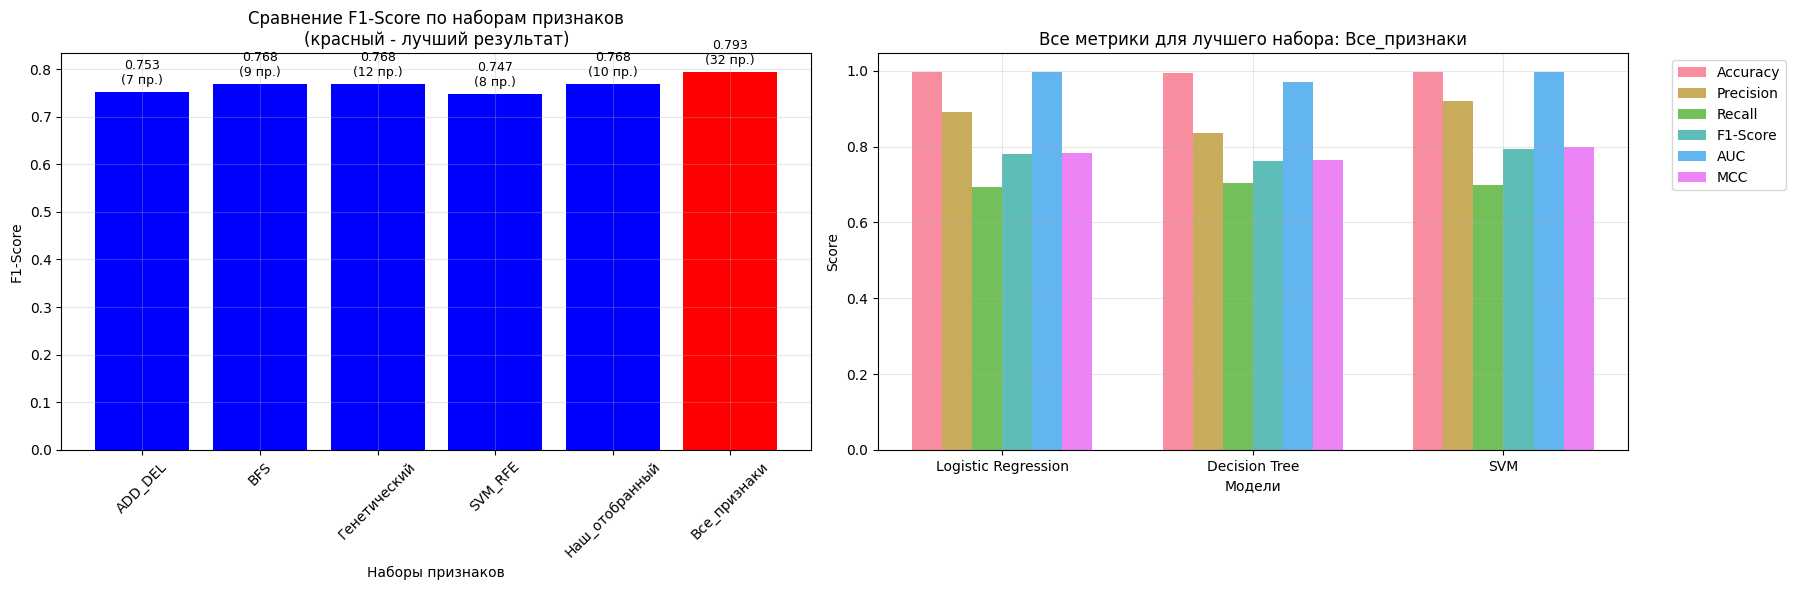

In [ ]:
"""# 18. Методы классификации для 6 разных наборов признаков с улучшенной выборкой"""

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, matthews_corrcoef)

# Определяем 6 наборов признаков
feature_sets = {
    'ADD_DEL': [
        'amount',                              # Сумма транзакции
        'cust_unique_merch_total',             # Количество уникальных мерчантов
        'cust_max_tx_per_day',                 # Максимальное количество транзакций в день
        'is_first_tx',                         # Первая ли это транзакция клиента
        "category_'es_fashion'",               # Мода
        "category_'es_hotelservices'",         # Гостиничные услуги
        "category_'es_tech'"                   # Техника и электроника
    ],

    'BFS': [
        'amount',                              # Сумма транзакции
        'cust_unique_merch_total',             # Количество уникальных мерчантов
        'cust_max_tx_per_day',                 # Максимальное количество транзакций в день
        'is_first_tx',                         # Первая ли это транзакция клиента
        "category_'es_fashion'",               # Мода
        "category_'es_hotelservices'",         # Гостиничные услуги
        "category_'es_leisure'",               # Досуг и развлечения
        "category_'es_sportsandtoys'",         # Спорт и игрушки
        "category_'es_tech'"                   # Техника и электроника
    ],

    'Генетический': [
        'amount',                              # Сумма транзакции
        'cust_unique_merch_total',             # Количество уникальных мерчантов
        'cust_max_tx_per_day',                 # Максимальное количество транзакций в день
        'is_first_tx',                         # Первая ли это транзакция клиента
        "category_'es_barsandrestaurants'",    # Бары и рестораны
        "category_'es_contents'",              # Контент
        "category_'es_fashion'",               # Мода
        "category_'es_food'",                  # Еда
        "category_'es_leisure'",               # Досуг и развлечения
        "category_'es_sportsandtoys'",         # Спорт и игрушки
        "category_'es_tech'",                  # Техника и электроника
        "category_'es_travel'"                 # Путешествия
    ],

    'SVM_RFE': [
        'amount',                              # Сумма транзакции
        'is_first_tx',                         # Первая ли это транзакция клиента
        'seen_merchant_before',                # Видел ли мерчанта раньше
        "category_'es_barsandrestaurants'",    # Бары и рестораны
        "category_'es_health'",                # Здоровье
        "category_'es_hyper'",                 # Крипта?
        "category_'es_leisure'",               # Досуг и развлечения
        "category_'es_wellnessandbeauty'"      # Beauty
    ],

    'Наш_отобранный': [
        'amount',                              # Сумма транзакции
        'cust_unique_merch_total',             # Количество уникальных мерчантов
        'cust_max_tx_per_day',                 # Максимальное количество транзакций в день
        'is_first_tx',                         # Первая ли это транзакция клиента
        "category_'es_barsandrestaurants'",    # Бары и рестораны
        "category_'es_fashion'",               # Мода
        "category_'es_hotelservices'",         # Гостиничные услуги
        "category_'es_leisure'",               # Досуг и развлечения
        "category_'es_sportsandtoys'",         # Спорт и игрушки
        "category_'es_tech'"                   # Техника и электроника
    ],

    'Все_признаки': scaled.columns.tolist()  # Все признаки из scaled
}

def evaluate_feature_set_with_stratified_sampling(features, feature_set_name, sample_size=150000):
    """
    Оценивает все три модели на заданном наборе признаков с использованием стратифицированной выборки
    """
    print(f"\n{'='*60}")
    print(f"📊 НАБОР ПРИЗНАКОВ: {feature_set_name}")
    print(f"📏 Количество признаков: {len(features)}")
    print(f"{'='*60}")

    # Проверяем доступность признаков
    available_features = [f for f in features if f in scaled.columns]
    if len(available_features) != len(features):
        print(f"⚠️  Предупреждение: {len(features) - len(available_features)} признаков не найдено")

    # ИСПОЛЬЗУЕМ ПРОСТУЮ СТРАТИФИЦИРОВАННУЮ ВЫБОРКУ
    X_sampled, y_sampled = get_simple_stratified_samples(
        scaled[available_features], fraud_labels,
        sample_size=sample_size, random_state=42
    )

    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_sampled, y_sampled, test_size=0.3, random_state=42, stratify=y_sampled
    )

    results = {}

    # 1. Логистическая регрессия
    print("\n🧮 ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ")
    lr_model = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_proba = lr_model.predict_proba(X_test)[:, 1]

    # ВЫЧИСЛЯЕМ 6 МЕТРИК
    lr_accuracy = accuracy_score(y_test, lr_pred)
    lr_precision = precision_score(y_test, lr_pred, zero_division=0)
    lr_recall = recall_score(y_test, lr_pred, zero_division=0)
    lr_f1 = f1_score(y_test, lr_pred, zero_division=0)
    lr_auc = roc_auc_score(y_test, lr_proba)
    lr_mcc = matthews_corrcoef(y_test, lr_pred)

    results['Logistic Regression'] = {
        'accuracy': lr_accuracy, 'precision': lr_precision, 'recall': lr_recall,
        'f1': lr_f1, 'auc': lr_auc, 'mcc': lr_mcc
    }

    print(f"   Accuracy:  {lr_accuracy:.4f}")
    print(f"   Precision: {lr_precision:.4f}")
    print(f"   Recall:    {lr_recall:.4f}")
    print(f"   F1:        {lr_f1:.4f}")
    print(f"   AUC:       {lr_auc:.4f}")
    print(f"   MCC:       {lr_mcc:.4f}")

    # 2. Дерево решений
    print("\n🌳 ДЕРЕВО РЕШЕНИЙ")
    dt_model = DecisionTreeClassifier(max_depth=8, min_samples_split=500, random_state=42)
    dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    dt_proba = dt_model.predict_proba(X_test)[:, 1]

    dt_accuracy = accuracy_score(y_test, dt_pred)
    dt_precision = precision_score(y_test, dt_pred, zero_division=0)
    dt_recall = recall_score(y_test, dt_pred, zero_division=0)
    dt_f1 = f1_score(y_test, dt_pred, zero_division=0)
    dt_auc = roc_auc_score(y_test, dt_proba)
    dt_mcc = matthews_corrcoef(y_test, dt_pred)

    results['Decision Tree'] = {
        'accuracy': dt_accuracy, 'precision': dt_precision, 'recall': dt_recall,
        'f1': dt_f1, 'auc': dt_auc, 'mcc': dt_mcc
    }

    print(f"   Accuracy:  {dt_accuracy:.4f}")
    print(f"   Precision: {dt_precision:.4f}")
    print(f"   Recall:    {dt_recall:.4f}")
    print(f"   F1:        {dt_f1:.4f}")
    print(f"   AUC:       {dt_auc:.4f}")
    print(f"   MCC:       {dt_mcc:.4f}")

    # 3. SVM
    print("\n⚡ SVM")
    svm_model = SVC(C=1.0, kernel='linear', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_proba = svm_model.predict_proba(X_test)[:, 1]

    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_precision = precision_score(y_test, svm_pred, zero_division=0)
    svm_recall = recall_score(y_test, svm_pred, zero_division=0)
    svm_f1 = f1_score(y_test, svm_pred, zero_division=0)
    svm_auc = roc_auc_score(y_test, svm_proba)
    svm_mcc = matthews_corrcoef(y_test, svm_pred)

    results['SVM'] = {
        'accuracy': svm_accuracy, 'precision': svm_precision, 'recall': svm_recall,
        'f1': svm_f1, 'auc': svm_auc, 'mcc': svm_mcc
    }

    print(f"   Accuracy:  {svm_accuracy:.4f}")
    print(f"   Precision: {svm_precision:.4f}")
    print(f"   Recall:    {svm_recall:.4f}")
    print(f"   F1:        {svm_f1:.4f}")
    print(f"   AUC:       {svm_auc:.4f}")
    print(f"   MCC:       {svm_mcc:.4f}")

    return results, available_features

"""# 19. Запуск тестирования всех 6 наборов признаков с улучшенной выборкой"""

print("🚀 ЗАПУСК ТЕСТИРОВАНИЯ 6 НАБОРОВ ПРИЗНАКОВ С СТРАТИФИЦИРОВАННОЙ ВЫБОРКОЙ")
print("=" * 80)

print(f"Создана KMeans модель с {len(available_continuous)} признаками для стратифицированного отбора")

all_results = {}

for set_name, features in feature_sets.items():
    try:
        results, used_features = evaluate_feature_set_with_stratified_sampling(
            features, set_name, sample_size=150000
        )
        all_results[set_name] = {
            'results': results,
            'feature_count': len(used_features),
            'features': used_features
        }
    except Exception as e:
        print(f"❌ Ошибка при тестировании {set_name}: {e}")
        continue

"""# 20. Сравнительный анализ всех наборов признаков с улучшенными метриками"""

print("\n🎯 СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ НАБОРОВ ПРИЗНАКОВ")
print("=" * 140)
print(f"{'Набор признаков':<18} {'Признаков':<10} {'Лучшая модель':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10} {'MCC':<10}")
print("-" * 140)

best_overall_f1 = {'score': 0, 'set': '', 'model': ''}
best_overall_auc = {'score': 0, 'set': '', 'model': ''}

for set_name, data in all_results.items():
    # Находим лучшую модель по F1-Score
    best_model = max(data['results'].items(), key=lambda x: x[1]['f1'])
    best_model_name = best_model[0]
    best_metrics = best_model[1]

    print(f"{set_name:<18} {data['feature_count']:<10} {best_model_name:<20} {best_metrics['accuracy']:<10.4f} {best_metrics['precision']:<10.4f} {best_metrics['recall']:<10.4f} {best_metrics['f1']:<10.4f} {best_metrics['auc']:<10.4f} {best_metrics['mcc']:<10.4f}")

    # Обновляем лучшие результаты
    if best_metrics['f1'] > best_overall_f1['score']:
        best_overall_f1 = {'score': best_metrics['f1'], 'set': set_name, 'model': best_model_name}
    if best_metrics['auc'] > best_overall_auc['score']:
        best_overall_auc = {'score': best_metrics['auc'], 'set': set_name, 'model': best_model_name}

print("-" * 140)
print(f"🏆 ЛУЧШИЙ ПО F1: {best_overall_f1['set']} + {best_overall_f1['model']} (F1: {best_overall_f1['score']:.4f})")
print(f"🏆 ЛУЧШИЙ ПО AUC: {best_overall_auc['set']} + {best_overall_auc['model']} (AUC: {best_overall_auc['score']:.4f})")

"""# 21. Визуализация результатов"""

# Визуализируем сравнение F1-score по всем наборам
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# График 1: F1-Score по наборам признаков
set_names = list(all_results.keys())
f1_scores = [max([model['f1'] for model in data['results'].values()]) for data in all_results.values()]
feature_counts = [data['feature_count'] for data in all_results.values()]

bars = ax1.bar(set_names, f1_scores, color=['red' if i == list(all_results.keys()).index(best_overall_f1['set']) else 'blue' for i in range(len(set_names))])
ax1.set_xlabel('Наборы признаков')
ax1.set_ylabel('F1-Score')
ax1.set_title('Сравнение F1-Score по наборам признаков\n(красный - лучший результат)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, score, count in zip(bars, f1_scores, feature_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}\n({count} пр.)', ha='center', va='bottom', fontsize=9)

# График 2: Все метрики для лучшего набора
best_set_data = all_results[best_overall_f1['set']]
models = list(best_set_data['results'].keys())
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'mcc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC', 'MCC']

x = np.arange(len(models))
width = 0.12

for i, metric in enumerate(metrics_to_plot):
    scores = [best_set_data['results'][model][metric] for model in models]
    ax2.bar(x + i*width, scores, width, label=metric_names[i], alpha=0.8)

ax2.set_xlabel('Модели')
ax2.set_ylabel('Score')
ax2.set_title(f'Все метрики для лучшего набора: {best_overall_f1["set"]}')
ax2.set_xticks(x + width*2.5)
ax2.set_xticklabels(models)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# """# 25. Полный анализ всех метрик для каждой модели"""

# from sklearn.metrics import (accuracy_score, precision_score, recall_score,
#                            f1_score, roc_auc_score, confusion_matrix,
#                            classification_report)

# def comprehensive_model_analysis(models_dict, X_test, y_test):
#     """
#     Полный анализ всех метрик для каждой модели
#     """
#     print("ПОЛНЫЙ АНАЛИЗ ВСЕХ МЕТРИК ДЛЯ КАЖДОЙ МОДЕЛИ")
#     print("=" * 90)

#     all_results = {}

#     for name, (model, y_pred, y_proba) in models_dict.items():
#         print(f"\n📊 {name.upper()}")
#         print("-" * 50)

#         # Основные метрики
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
#         roc_auc = roc_auc_score(y_test, y_proba)

#         # Матрица ошибок
#         cm = confusion_matrix(y_test, y_pred)
#         tn, fp, fn, tp = cm.ravel()

#         # Дополнительные метрики
#         specificity = tn / (tn + fp)  # True Negative Rate
#         false_positive_rate = fp / (fp + tn)

#         # Сохраняем результаты
#         all_results[name] = {
#             'accuracy': accuracy,
#             'precision': precision,
#             'recall': recall,
#             'f1_score': f1,
#             'roc_auc': roc_auc,
#             'specificity': specificity,
#             'false_positive_rate': false_positive_rate,
#             'confusion_matrix': cm,
#             'y_pred': y_pred,
#             'y_proba': y_proba
#         }

#         # Выводим основные метрики
#         print("ОСНОВНЫЕ МЕТРИКИ:")
#         print(f"├── Accuracy:       {accuracy:.4f}")
#         print(f"├── Precision:      {precision:.4f}")
#         print(f"├── Recall:         {recall:.4f}")
#         print(f"├── F1-Score:       {f1:.4f}")
#         print(f"├── ROC-AUC:        {roc_auc:.4f}")
#         print(f"├── Specificity:    {specificity:.4f}")
#         print(f"└── FPR:            {false_positive_rate:.4f}")

#         # Матрица ошибок
#         print(f"\nМАТРИЦА ОШИБОК:")
#         print(f"[[TN={tn:5d}  FP={fp:3d}]")
#         print(f" [FN={fn:5d}  TP={tp:3d}]]")

#         # Classification report
#         print(f"\nDETAILED CLASSIFICATION REPORT:")
#         print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

#         print("=" * 50)

#     return all_results

# # Запускаем полный анализ
# all_results = comprehensive_model_analysis(models_dict, X_test, y_test)

# """# 26. Сравнительная таблица всех моделей"""

# # Создаем сравнительную таблицу
# print("\n📈 СРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МОДЕЛЕЙ")
# print("=" * 100)
# print(f"{'Метрика':<15} {'Logistic Regression':<20} {'Decision Tree':<18} {'SVM':<15} {'ЛУЧШАЯ':<10}")
# print("-" * 100)

# metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'specificity']

# for metric in metrics_to_compare:
#     lr_val = all_results['Logistic Regression'][metric]
#     dt_val = all_results['Decision Tree'][metric]
#     svm_val = all_results['SVM'][metric]

#     # Находим лучшую модель для этой метрики
#     best_value = max(lr_val, dt_val, svm_val)
#     best_model = ''
#     if best_value == lr_val: best_model = 'LR'
#     elif best_value == dt_val: best_model = 'DT'
#     else: best_model = 'SVM'

#     print(f"{metric:<15} {lr_val:<20.4f} {dt_val:<18.4f} {svm_val:<15.4f} {best_model:<10}")

# """# 27. Визуализация сравнения метрик"""

# # Визуализируем сравнение метрик
# metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Specificity']
# lr_scores = [all_results['Logistic Regression'][m] for m in metrics_to_compare]
# dt_scores = [all_results['Decision Tree'][m] for m in metrics_to_compare]
# svm_scores = [all_results['SVM'][m] for m in metrics_to_compare]

# x = np.arange(len(metrics_names))
# width = 0.25

# fig, ax = plt.subplots(figsize=(14, 8))
# rects1 = ax.bar(x - width, lr_scores, width, label='Logistic Regression', alpha=0.8)
# rects2 = ax.bar(x, dt_scores, width, label='Decision Tree', alpha=0.8)
# rects3 = ax.bar(x + width, svm_scores, width, label='SVM', alpha=0.8)

# ax.set_xlabel('Метрики')
# ax.set_ylabel('Score')
# ax.set_title('Сравнение моделей по всем метрикам')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_names, rotation=45)
# ax.legend()
# ax.grid(True, alpha=0.3)

# # Добавляем значения на столбцы
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate(f'{height:.3f}',
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=9)

# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)

# plt.tight_layout()
# plt.show()

# """# 28. Итоговый вывод по моделям"""

# print("\n🎯 ИТОГОВЫЙ ВЫВОД ПО МОДЕЛЯМ")
# print("=" * 60)

# # Находим лучшую модель по F1-Score (основная метрика для fraud)
# best_f1_model = max(all_results.items(), key=lambda x: x[1]['f1_score'])[0]
# best_f1_score = all_results[best_f1_model]['f1_score']

# # Находим лучшую модель по ROC-AUC
# best_auc_model = max(all_results.items(), key=lambda x: x[1]['roc_auc'])[0]
# best_auc_score = all_results[best_auc_model]['roc_auc']

# # Находим лучшую модель по Precision
# best_precision_model = max(all_results.items(), key=lambda x: x[1]['precision'])[0]
# best_precision_score = all_results[best_precision_model]['precision']

# print(f"🏆 Лучшая модель по F1-Score: {best_f1_model} ({best_f1_score:.4f})")
# print(f"📊 Лучшая модель по ROC-AUC: {best_auc_model} ({best_auc_score:.4f})")
# print(f"🎯 Лучшая модель по Precision: {best_precision_model} ({best_precision_score:.4f})")

# print(f"\n💡 РЕКОМЕНДАЦИИ:")
# print(f"• Для минимизации ложных срабатываний: {best_precision_model}")
# print(f"• Для баланса между обнаружением и точностью: {best_f1_model}")
# print(f"• Для общей способности разделять классы: {best_auc_model}")